# Project Productie Proces
- Carlo Dieltjens - Raf Mesotten - Yannick Pottiez
- April 2024

## Stap 0: Importeren

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import json
import sys
import matplotlib.pyplot as plt 
import scipy.stats as stats
from scipy.stats import cauchy

In [2]:
# Vermijd toekomstige deprecated-fouten bij onder meer histogrammen
pd.set_option('future.no_silent_downcasting', True)

#### Functies

In [4]:
sys.path.append('../scripts')  # definieer path met scripts
from segment_calculations import create_segments
from segment_calculations import calculate_segment_shares

## Stap 1: Gegevens downloaden en organiseren
Alle input staat in de folder ```data\input```.

In [5]:
input_path = os.path.join('..', 'data', 'input')

## Stap 2: Git Repository initialiseren
https://github.com/craftyraf/project-productie-proces

## Stap 3: Creëer een virtuele omgeving met Anaconda
Enkel de nodige pakketten werden geinstalleerd.
In README.md staat uitgelegd hoe je je virtual environment kan opzetten.

## Stap 4a: Lezen van gegevens in Python

#### Inlezen van 1 .json bestand

In [6]:
df = pd.read_json(os.path.join(input_path, 
                               'data_productie', 
                               'daily_production', 
                               'BRU', 
                               '20180101.json'), 
                  orient='index')
df

,0
DoW,Monday
hour,1
minute,0
date,01-01-2018 00:00:00.0000
maintenance,No
prod_loss,61
prod_loss_perc,5
production,1183


#### Inlezen van alle .json bestanden + samenvoegen in 1 dataframe voor alle locaties (met extra kolom: 'location')

In [7]:
# Functie om JSON-bestanden te lezen en DataFrame te maken
def read_json_files(directory_path, location):
    dataframes = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            full_path = os.path.join(directory_path, filename)
            with open(full_path, 'r') as f:
                json_data = json.load(f)
                df = pd.DataFrame([json_data])
                df['location'] = location  # Voeg 'location' kolom toe met locatienaam
                dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

# Definieer paden voor BRU en STO
directory_path_BRU = os.path.join(input_path, 'data_productie', 'daily_production', 'BRU')
directory_path_STO = os.path.join(input_path, 'data_productie', 'daily_production', 'STO')

# Lees JSON-bestanden en maak DataFrame met 'Location' kolom
BRU_df = read_json_files(directory_path_BRU, 'BRU')
STO_df = read_json_files(directory_path_STO, 'STO')

# Concateneer BRU en STO DataFrames
combined_df = pd.concat([BRU_df, STO_df], ignore_index=True)

# Toon gecombineerde DataFrame
combined_df

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,location
0,Monday,1,0,01-01-2018 00:00:00.0000,No,61,5,1183,BRU
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,106,9,1138,BRU
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,129,10,1115,BRU
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,278,22,966,BRU
4,Friday,1,0,01-05-2018 00:00:00.0000,No,218,17,1026,BRU
...,...,...,...,...,...,...,...,...,...
3655,Saturday,1,0,12-31-2022 00:00:00.0000,No,51,19,223,STO
3656,Sunday,1,0,01-01-2023 00:00:00.0000,No,53,20,221,STO
3657,Monday,1,0,01-02-2023 00:00:00.0000,No,61,22,213,STO
3658,Tuesday,1,0,01-03-2023 00:00:00.0000,No,70,25,204,STO


#### Filter alle records waarbij onderhoud plaatsvond

In [8]:
# Unieke waarden met hun aantallen voor 'maintenance' in BRU_df
unique_values_counts = combined_df['maintenance'].value_counts()
print(unique_values_counts)

# Behoud enkel de records met 'maintenance = No'
combined_df_no_maintenance = combined_df[combined_df['maintenance'] == 'No']

maintenance
No     3452
Yes     208
Name: count, dtype: int64


#### Controle of er NaN-waarden in het dataframe zit

Er zitten geen NaN-waarden in combined_df_no_maintenance:

In [9]:
print("Aantal NaN-waarden per kolom in combined_df_no_maintenance:")
for column in combined_df_no_maintenance.columns:
    nan_count = combined_df_no_maintenance[column].isna().sum()
    print(f"{column}: {nan_count}")

Aantal NaN-waarden per kolom in combined_df_no_maintenance:
DoW: 0
hour: 0
minute: 0
date: 0
maintenance: 0
prod_loss: 0
prod_loss_perc: 0
production: 0
location: 0


#### Check datatypes en converteer naar het juiste format

In [10]:
combined_df_no_maintenance.dtypes

DoW               object
hour               int64
minute             int64
date              object
maintenance       object
prod_loss         object
prod_loss_perc    object
production        object
location          object
dtype: object

In [12]:
# Maak een nieuwe DataFrame met de schoongemaakte numerieke kolommen
combined_df_cleaned = combined_df_no_maintenance.copy()

# Converteer de kolommen naar numerieke datatypes
combined_df_cleaned['prod_loss'] = pd.to_numeric(combined_df_cleaned['prod_loss'], errors='coerce')
combined_df_cleaned['prod_loss_perc'] = pd.to_numeric(combined_df_cleaned['prod_loss_perc'], errors='coerce')
combined_df_cleaned['production'] = pd.to_numeric(combined_df_cleaned['production'], errors='coerce')

# Print de datatypes van de nieuwe DataFrame om te controleren
print(combined_df_cleaned.dtypes)

DoW               object
hour               int64
minute             int64
date              object
maintenance       object
prod_loss          int64
prod_loss_perc     int64
production         int64
location          object
dtype: object


#### Creëer een histogram per locatie

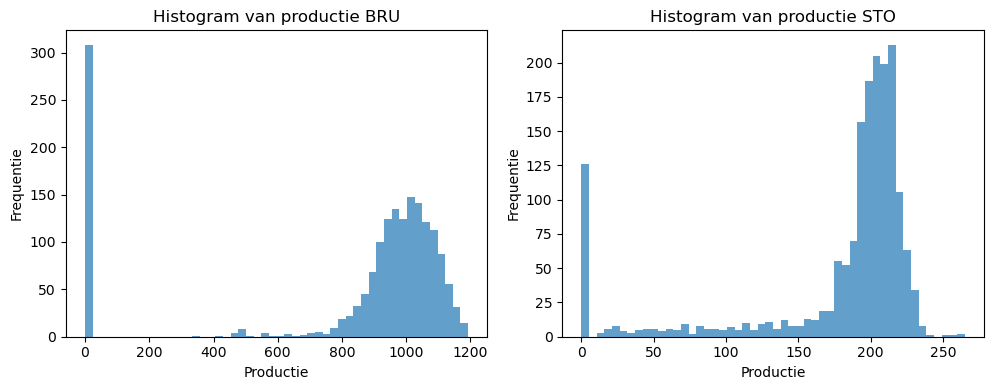

In [13]:
# Verkrijg de unieke locaties
unique_locations = combined_df_cleaned['location'].unique()

# Bereken het aantal rijen/kolommen benodigd voor de subplots
n_locs = len(unique_locations)
n_cols = 3  # Kies bijvoorbeeld 3 kolommen of een ander gewenst aantal
n_rows = n_locs // n_cols + (n_locs % n_cols > 0)

# Creëer een figuur en assen voor de subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

for i, loc in enumerate(unique_locations):
    # Bereken de huidige rij en kolom
    row = i // n_cols
    col = i % n_cols
    
    # Filter de data voor de huidige locatie
    loc_data = combined_df_cleaned[combined_df_cleaned['location'] == loc]['production']
    
    # Plot histogram van productie voor de huidige locatie
    axs[row, col].hist(loc_data, bins=50, alpha=0.7)
    axs[row, col].set_title(f'Histogram van productie {loc}')
    axs[row, col].set_xlabel('Productie')
    axs[row, col].set_ylabel('Frequentie')

# Verberg overbodige subplots als het aantal locaties niet perfect in de grid past
for i in range(n_locs, n_rows * n_cols):
    fig.delaxes(axs.flatten()[i])

# Toon de plot
plt.tight_layout()
plt.show()

### Stap 5: Bepaal een geschikte verdeling voor het dagelijkse productieproces

In bovenstaande grafieken is duidelijk zichtbaar dat een normaalverdeling niet zal volstaan om de data te fitten. Reden is de grote piek ter hoogte van 0, maar ook de lange linkerstaart samen met de korte rechterstaart. Om die reden besluiten we onze histogrammen (visueel) op te delen in 3 delen, en voor elk deel een geschikte fit te vinden.

#### BRU

In [17]:
# Gebruik de functie 'create_segments' om de segmenten te maken (grenzen werden visueel bepaald)
segment_1, segment_2, segment_3, \
location, threshold_1, threshold_2, \
total_days_location = create_segments('BRU', 10**(-8), 750, combined_df_cleaned)

# Bereken het aandeel van elk van de segmenten
calculate_segment_shares(location, segment_1, segment_2, segment_3, threshold_1, threshold_2, total_days_location)

BRU: % dagen met [productie < 1e-08]: 17.74 %
BRU: % dagen met [1e-08 <= productie < 750]: 2.13 %
BRU: % dagen met [productie >= 750]: 80.13 %


In [ ]:
# Maak een grafiek van elk segment
plt.subplots(1, 3, figsize=(25, 6), gridspec_kw={'width_ratios': [4, 4, 4]}) 

# Segment 1: Productie = 0
plt.subplot(1, 3, 1)
data_norm_1 = segment_1['production']

# Bepaal xmax als het maximum van de productie van de desbetreffende locatie
# afgerond naar boven naar het dichtstbijzijnde veelvoud van 50, vermeerderd met 100.
x_max = int(np.ceil(combined_df_cleaned[combined_df_cleaned['location'] == location]['production'].max() / 50) * 50) + 100

plt.xlim(xmin=0, xmax = x_max)
plt.hist(data_norm_1, bins=1, density=True, alpha=0.6, color='g', width=50)

plt.title(f"{location} Productie < {threshold_1}")
plt.xlabel('Productie')
plt.ylabel('Dichtheid')

# Segment 2: uniforme verdeling
plt.subplot(1, 3, 2)
data_norm_2 = segment_2['production']
mean_norm_2, std_norm_2 = stats.uniform.fit(data_norm_2)

plt.hist(data_norm_2, bins=50, density=True, alpha=0.6, color='g', label='Histogram')

xmin, xmax = plt.xlim()
plt.xlim(xmin=0, xmax = 1250)
x_norm_2 = np.linspace(xmin, xmax, 100)
p_norm_2 = stats.uniform.pdf(x_norm_2, mean_norm_2, std_norm_2)
plt.plot(x_norm_2, p_norm_2, 'k', linewidth=2, label='Uniforme verdeling')

plt.title(f"{threshold_1} <= {location} Productie < {threshold_2}")
plt.xlabel('Productie')
plt.ylabel('Dichtheid')
plt.legend()

# Segment 3: standaardnormale verdeling
plt.subplot(1, 3, 3) # row 1, col 2 index 3
data_norm_3 = segment_3['production']
mean_norm_3, std_norm_3 = stats.norm.fit(data_norm_3)

# Histogram voor BRU_prod_df rechterkant
plt.hist(data_norm_3, bins=50, density=True, alpha=0.6, color='g', label='Histogram')

xmin, xmax = plt.xlim()
plt.xlim(xmin=0, xmax = 1250)
x_norm_3 = np.linspace(xmin, xmax, 100)
p_norm_3 = stats.norm.pdf(x_norm_3, mean_norm_3, std_norm_3)
plt.plot(x_norm_3, p_norm_3, 'k', linewidth=2, label='Normaalverdeling')

plt.title(f"{location} Productie >= {threshold_2}")
plt.xlabel('Productie')
plt.ylabel('Dichtheid')
plt.legend()

plt.subplots_adjust(wspace=0.2) 
plt.show()

#### STO

In [16]:
# Gebruik de functie 'create_segments' om de segmenten te maken (grenzen werden visueel bepaald)
segment_1, segment_2, segment_3, \
location, threshold_1, threshold_2, \
total_days_location = create_segments('STO', 10**(-8), 150, combined_df_cleaned)

# Bereken het aandeel van elk van de segmenten
calculate_segment_shares(location, segment_1, segment_2, segment_3, threshold_1, threshold_2, total_days_location)

STO: % dagen met [productie < 1e-08]: 7.34 %
STO: % dagen met [1e-08 <= productie < 150]: 9.62 %
STO: % dagen met [productie >= 150]: 83.04 %


In [ ]:

plt.subplots(1, 3, figsize=(25, 3), gridspec_kw={'width_ratios': [4, 4, 4]}) 

#Segment 1: Productie = 0
plt.subplot(1, 3, 1)
data_bru_norm_1 = STO_segment_1['production']

plt.xlim(xmin=0, xmax = 275)
plt.hist(data_bru_norm_1, bins=1, density=True, alpha=0.6, color='b', width=5)

plt.title('STO Productie = 0')
plt.xlabel('Productie')
plt.ylabel('Dichtheid')

# Segment 2: uniforme verdeling
plt.subplot(1, 3, 2)
data_sto_norm_2 = STO_segment_2['production']
mean_sto_norm_2, std_sto_norm_2 = stats.uniform.fit(data_sto_norm_2)

plt.hist(data_sto_norm_2, bins=50, density=True, alpha=0.6, color='b', label='Histogram')

xmin, xmax = plt.xlim()
plt.xlim(xmin=0, xmax = 275)
x_sto_norm_2 = np.linspace(xmin, xmax, 100)
p_sto_norm_2 = stats.uniform.pdf(x_sto_norm_2, mean_sto_norm_2, std_sto_norm_2)
plt.plot(x_sto_norm_2, p_sto_norm_2, 'k', linewidth=2, label='Uniforme verdeling')

plt.title('0 < STO Productie < 150')
plt.xlabel('Productie')
plt.ylabel('Dichtheid')
plt.legend()

#Segment 3: Cauchy verdeling
plt.subplot(1, 3, 3)
data_sto_norm_3 = STO_segment_3['production']
mean_sto_norm_3, std_sto_norm_3 = stats.norm.fit(data_sto_norm_3)

loc_sto_3, scale_sto_3 = cauchy.fit(data_sto_norm_3)
# scale_sto_3 *= 1 # maak piek van cauchy verdeling scherper

# Histogram STO_prod_df
plt.hist(data_sto_norm_3, bins=50, density=True, alpha=0.6, color='b', label='Histogram')

# Cauchy verdeling for STO_prod_df
xmin, xmax = plt.xlim()
x_sto_3 = np.linspace(xmin, xmax, 100)
p_sto_3 = cauchy.pdf(x_sto_3, loc=loc_sto_3, scale=scale_sto_3)
plt.plot(x_sto_3, p_sto_3, 'k', linewidth=2, label='Cauchy verdeling')

plt.title('Histogram en Cauchy verdeling van productie Stockholm')
plt.xlabel('Productie')
plt.ylabel('Dichtheid')
plt.legend()
plt.show()

plt.subplots_adjust(wspace=0.2) 
plt.show()

### Stap 6: Simulatieprogramma ontwikkelen

In [ ]:
# Functie om de productie te simuleren
def simulate_production(n, mean, std):
    # Genereer een array van normaal verdeelde productiewaarden
    production_values = np.random.normal(mean, std, n)
    
    # Initialiseer een lege lijst om de gesimuleerde producties op te slaan
    simulated_production = []
    
    # Simuleer de productie voor elke dag
    for value in production_values:
        # Bereken de kans op 0 productie met de cumulatieve distributiefunctie (CDF) van de normaalverdeling
        zero_production_prob = stats.norm.cdf(0, loc=value, scale=std)
        
        # Genereer een willekeurige waarde tussen 0 en 1
        random_prob = np.random.rand()
        
        # Bepaal de gesimuleerde productiewaarde op basis van de kans
        if random_prob < zero_production_prob:
            simulated_production.append(0)
        else:
            simulated_production.append(value)
    
    return simulated_production

# Parameters voor de normaalverdeling (gemiddelde en standaarddeviatie)
mean = mean_bru  # Gemiddelde productie
std = std_bru   # Standaarddeviatie van de productie

# Vraag de gebruiker om de duur van de simulatie (n dagen)
n = int(input("Voer het aantal dagen in voor de simulatie: "))

# Simuleer de productie
simulated_data = simulate_production(n, mean, std)

# Toon de gesimuleerde productiewaarden
print("Gesimuleerde productiewaarden:")
for i, value in enumerate(simulated_data, 1):
    print(f"Dag {i}: {value}")

# Plot de gesimuleerde productiewaarden
plt.plot(simulated_data, marker='o')
plt.title('Gesimuleerde productiewaarden over de tijd')
plt.xlabel('Dag')
plt.ylabel('Productie')
plt.grid(True)
plt.show()


Simuleer productie per dag, uitgaand van normale verdeling (obv avg en std, kan via np.random.normal-simulatie)
Deze simulatie voor één dag simuleer je 10**5

En dit simuleer je voor 7 dagen (dus gebruik model voor periode dat je wil en tel observaties op)
Maak er cumulatieve distributieplot van

Twee vragen:
- Wat met onderscheid? Groene (voll productie) / blauw /  rode (0 productie) steek je apart in model (geel neem je niet mee):
(Kans op 0, kans op voll, kans op blauw berekenen?)
- Waar zit het 10**5 simuleren in jouw logica? (wat dan daarna voor n (7) dagen moet gesimuleerd worden?




# 7 Gebruik je simulatie

In [ ]:
segment_1 = 